Dataset loaded successfully!
Shape: (1000, 12)

First few rows:
   age  gender  fever  cough  fatigue  difficulty_breathing  blood_pressure  \
0   69       0      0      0        0                     0             123   
1   32       1      1      0        0                     1             133   
2   78       1      0      1        1                     1             104   
3   38       1      1      0        1                     0             167   
4   41       0      1      1        0                     1             159   

   cholesterol_level  blood_sugar  heart_rate   bmi        disease  
0                288          152          60  20.1        Healthy  
1                167          135         109  18.5        Healthy  
2                199           89          86  19.2        Healthy  
3                291          102         112  19.2  Heart Disease  
4                267          141         106  38.0  Heart Disease  

Disease distribution:
disease
Healthy         

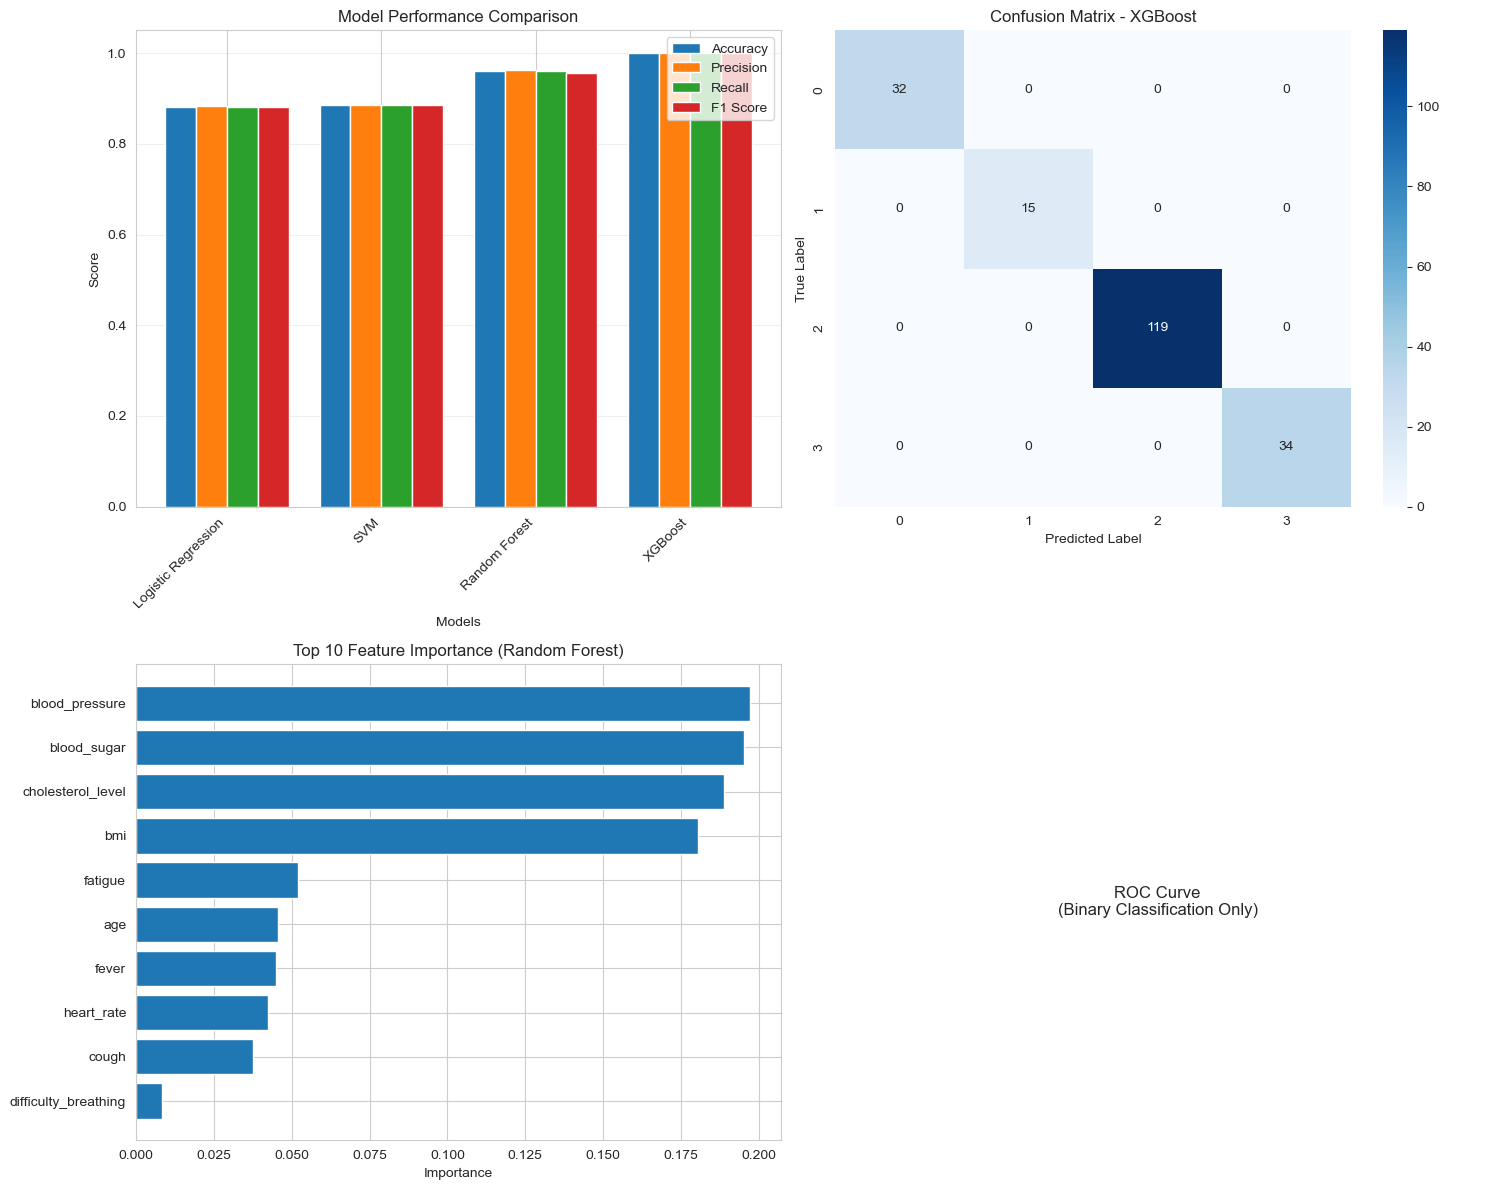


EXAMPLE: Predicting for a new patient

DISEASE PREDICTION
Model Used: XGBoost
Predicted Disease: Flu

Probabilities:
  Diabetes: 0.02%
  Flu: 99.33%
  Healthy: 0.64%
  Heart Disease: 0.01%

To use with your own data:
1. Replace sample_data=True with filepath='your_data.csv'
2. Ensure your CSV has symptom columns and a 'disease' column
3. Adjust feature names in the predict_disease() function


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class DiseasePredictionSystem:
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.results = {}
        
    def load_data(self, filepath=None, sample_data=True):
        """Load medical data from file or generate sample data"""
        if sample_data:
            # Generate synthetic medical data
            np.random.seed(42)
            n_samples = 1000
            
            data = {
                'age': np.random.randint(18, 85, n_samples),
                'gender': np.random.choice([0, 1], n_samples),
                'fever': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
                'cough': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
                'fatigue': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
                'difficulty_breathing': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
                'blood_pressure': np.random.randint(90, 180, n_samples),
                'cholesterol_level': np.random.randint(150, 300, n_samples),
                'blood_sugar': np.random.randint(70, 200, n_samples),
                'heart_rate': np.random.randint(60, 120, n_samples),
                'bmi': np.random.uniform(18, 40, n_samples).round(1)
            }
            
            # Create disease labels based on features (simplified logic)
            disease = []
            for i in range(n_samples):
                if data['fever'][i] and data['cough'][i] and data['fatigue'][i]:
                    disease.append('Flu')
                elif data['blood_pressure'][i] > 140 and data['cholesterol_level'][i] > 240:
                    disease.append('Heart Disease')
                elif data['blood_sugar'][i] > 140 and data['bmi'][i] > 30:
                    disease.append('Diabetes')
                else:
                    disease.append('Healthy')
            
            data['disease'] = disease
            self.df = pd.DataFrame(data)
        else:
            self.df = pd.read_csv(filepath)
        
        print("Dataset loaded successfully!")
        print(f"Shape: {self.df.shape}")
        print(f"\nFirst few rows:\n{self.df.head()}")
        print(f"\nDisease distribution:\n{self.df['disease'].value_counts()}")
        return self.df
    
    def preprocess_data(self, target_column='disease'):
        """Preprocess the medical data"""
        print("\n" + "="*50)
        print("PREPROCESSING DATA")
        print("="*50)
        
        # Separate features and target
        X = self.df.drop(target_column, axis=1)
        y = self.df[target_column]
        
        # Encode target variable
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Handle missing values
        X = X.fillna(X.mean())
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.X_train = X_train_scaled
        self.X_test = X_test_scaled
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = X.columns.tolist()
        
        print(f"Training set size: {X_train.shape[0]}")
        print(f"Testing set size: {X_test.shape[0]}")
        print(f"Number of features: {X_train.shape[1]}")
        print(f"Number of classes: {len(np.unique(y_encoded))}")
        
    def train_models(self):
        """Train multiple classification models"""
        print("\n" + "="*50)
        print("TRAINING MODELS")
        print("="*50)
        
        # Define models
        self.models = {
            'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
            'SVM': SVC(kernel='rbf', probability=True, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
        }
        
        # Train and evaluate each model
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            model.fit(self.X_train, self.y_train)
            
            # Predictions
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test) if hasattr(model, 'predict_proba') else None
            
            # Metrics
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred, average='weighted')
            recall = recall_score(self.y_test, y_pred, average='weighted')
            f1 = f1_score(self.y_test, y_pred, average='weighted')
            
            # Cross-validation score
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5)
            
            self.results[name] = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'cv_score': cv_scores.mean(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"{name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, CV Score: {cv_scores.mean():.4f}")
    
    def evaluate_models(self):
        """Evaluate and compare models"""
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        
        # Create comparison dataframe
        comparison_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'Accuracy': [self.results[m]['accuracy'] for m in self.results],
            'Precision': [self.results[m]['precision'] for m in self.results],
            'Recall': [self.results[m]['recall'] for m in self.results],
            'F1-Score': [self.results[m]['f1_score'] for m in self.results],
            'CV Score': [self.results[m]['cv_score'] for m in self.results]
        })
        
        print("\n", comparison_df.to_string(index=False))
        
        # Find best model
        best_model_name = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
        print(f"\nBest Model: {best_model_name}")
        
        return comparison_df
    
    def plot_results(self):
        """Visualize model performance"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Model Comparison Bar Plot
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        model_names = list(self.results.keys())
        
        x = np.arange(len(model_names))
        width = 0.2
        
        for i, metric in enumerate(metrics):
            values = [self.results[m][metric] for m in model_names]
            axes[0, 0].bar(x + i*width, values, width, label=metric.replace('_', ' ').title())
        
        axes[0, 0].set_xlabel('Models')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Model Performance Comparison')
        axes[0, 0].set_xticks(x + width * 1.5)
        axes[0, 0].set_xticklabels(model_names, rotation=45, ha='right')
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)
        
        # 2. Confusion Matrix (Best Model)
        best_model = max(self.results.items(), key=lambda x: x[1]['accuracy'])
        cm = confusion_matrix(self.y_test, best_model[1]['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
        axes[0, 1].set_title(f'Confusion Matrix - {best_model[0]}')
        axes[0, 1].set_ylabel('True Label')
        axes[0, 1].set_xlabel('Predicted Label')
        
        # 3. Feature Importance (Random Forest)
        if 'Random Forest' in self.results:
            rf_model = self.results['Random Forest']['model']
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False).head(10)
            
            axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'])
            axes[1, 0].set_xlabel('Importance')
            axes[1, 0].set_title('Top 10 Feature Importance (Random Forest)')
            axes[1, 0].invert_yaxis()
        
        # 4. ROC Curve (if binary classification)
        if len(np.unique(self.y_test)) == 2:
            for name, result in self.results.items():
                if result['y_pred_proba'] is not None:
                    fpr, tpr, _ = roc_curve(self.y_test, result['y_pred_proba'][:, 1])
                    roc_auc = auc(fpr, tpr)
                    axes[1, 1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
            
            axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
            axes[1, 1].set_xlabel('False Positive Rate')
            axes[1, 1].set_ylabel('True Positive Rate')
            axes[1, 1].set_title('ROC Curves')
            axes[1, 1].legend()
            axes[1, 1].grid(alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'ROC Curve\n(Binary Classification Only)', 
                           ha='center', va='center', fontsize=12)
            axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def predict_disease(self, patient_data):
        """Predict disease for new patient data"""
        # Get best model
        best_model_name = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        best_model = self.results[best_model_name]['model']
        
        # Prepare input
        patient_df = pd.DataFrame([patient_data])
        patient_scaled = self.scaler.transform(patient_df)
        
        # Predict
        prediction = best_model.predict(patient_scaled)
        prediction_proba = best_model.predict_proba(patient_scaled)
        
        # Decode prediction
        disease_name = self.label_encoder.inverse_transform(prediction)[0]
        
        print(f"\n{'='*50}")
        print("DISEASE PREDICTION")
        print(f"{'='*50}")
        print(f"Model Used: {best_model_name}")
        print(f"Predicted Disease: {disease_name}")
        print(f"\nProbabilities:")
        for i, disease in enumerate(self.label_encoder.classes_):
            print(f"  {disease}: {prediction_proba[0][i]*100:.2f}%")
        
        return disease_name, prediction_proba

# Main execution
if __name__ == "__main__":
    # Initialize system
    dps = DiseasePredictionSystem()
    
    # Load data (using sample data)
    dps.load_data(sample_data=True)
    
    # Preprocess data
    dps.preprocess_data()
    
    # Train models
    dps.train_models()
    
    # Evaluate models
    comparison_df = dps.evaluate_models()
    
    # Visualize results
    dps.plot_results()
    
    # Example prediction for a new patient
    print("\n" + "="*50)
    print("EXAMPLE: Predicting for a new patient")
    print("="*50)
    
    new_patient = {
        'age': 45,
        'gender': 1,
        'fever': 1,
        'cough': 1,
        'fatigue': 1,
        'difficulty_breathing': 0,
        'blood_pressure': 130,
        'cholesterol_level': 200,
        'blood_sugar': 95,
        'heart_rate': 78,
        'bmi': 25.5
    }
    
    disease, proba = dps.predict_disease(new_patient)
    
    print("\n" + "="*50)
    print("To use with your own data:")
    print("="*50)
    print("1. Replace sample_data=True with filepath='your_data.csv'")
    print("2. Ensure your CSV has symptom columns and a 'disease' column")
    print("3. Adjust feature names in the predict_disease() function")
    print("="*50)